In [15]:
#
# A GUIDE TO CODING INTERRUPTED TIME SERIES (ITS) ANALYSIS
# Adapted for the Wikipedia Revisions DataFrame
#
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [4]:
input_file = "normalized_everything100percat_with_ai_votes.csv"


In [16]:


def run_its_analysis(df_monthly, feature_to_analyze, intervention_date, show_plot=True, print_summary=True):
    """
    Performs an Interrupted Time Series (ITS) analysis for a specified feature.

    Args:
        df_monthly (pd.DataFrame): DataFrame with monthly aggregated data.
                                   Must include 'snapshot_ts', 'time', 'intervention',
                                   and 'post_intervention_time' columns.
        feature_to_analyze (str): The name of the dependent variable column to analyze.
        intervention_date (pd.Timestamp): The date of the intervention.
        show_plot (bool): If True, displays the ITS plot. Defaults to True.
        print_summary (bool): If True, prints the model summary and diagnostics. Defaults to True.

    Returns:
        statsmodels.regression.linear_model.RegressionResultsWrapper: The fitted model object.
    """
    if feature_to_analyze not in df_monthly.columns:
        print(f"Error: Feature '{feature_to_analyze}' not found in the DataFrame.")
        return None

    if df_monthly[feature_to_analyze].isnull().all():
        print(f"Skipping '{feature_to_analyze}' because it contains only NaN values.")
        return None

    # --- Step 4: Specify and Fit the ITS Model ---
    model_formula = f'{feature_to_analyze} ~ time + intervention + post_intervention_time'
    model = smf.ols(formula=model_formula, data=df_monthly).fit()

    if print_summary:
        # --- Step 5: Interpret the Model Results ---
        print(f"\n--- ITS Model Results for '{feature_to_analyze}' ---")
        print(model.summary())

        # --- Step 7: Diagnostic Check for Autocorrelation ---
        durbin_watson_stat = sm.stats.durbin_watson(model.resid)
        print(f"\n--- Diagnostic Check for '{feature_to_analyze}' ---")
        print(f"Durbin-Watson Statistic: {durbin_watson_stat:.4f}")
        print("A value near 2.0 suggests no significant first-order autocorrelation.")

    if show_plot:
        # --- Step 6: Visualize the Results ---
        plot_df = df_monthly.copy()
        plot_df['pred_pre'] = model.predict(plot_df.assign(intervention=0, post_intervention_time=0))
        plot_df['pred_post'] = model.predict(plot_df)
        plot_df['pred_counterfactual'] = model.predict(plot_df.assign(intervention=0, post_intervention_time=0))

        plt.figure(figsize=(12, 8))
        plt.scatter(plot_df['snapshot_ts'], plot_df[feature_to_analyze], label='Observed Monthly Mean', color='gray', alpha=0.7)

        pre_intervention_data = plot_df[plot_df['intervention'] == 0]
        plt.plot(pre_intervention_data['snapshot_ts'], pre_intervention_data['pred_pre'], label='Pre-Intervention Trend', color='blue')

        post_intervention_data = plot_df[plot_df['intervention'] == 1]
        plt.plot(post_intervention_data['snapshot_ts'], post_intervention_data['pred_post'], label='Post-Intervention Trend', color='red')
        plt.plot(post_intervention_data['snapshot_ts'], post_intervention_data['pred_counterfactual'], label='Counterfactual Trend', color='blue', linestyle='--')

        plt.axvline(x=intervention_date, color='black', linestyle='--', label=f"Intervention ({intervention_date.strftime('%b %Y')})")
        plt.title(f'Interrupted Time Series Analysis of {feature_to_analyze}', fontsize=16)
        plt.xlabel('Date (Month)', fontsize=12)
        plt.ylabel(f'Mean {feature_to_analyze}', fontsize=12)
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()

    return model

# --- Bulk Analysis Function for All Features ---

def run_bulk_its_analysis(df_monthly, feature_columns, intervention_date):
    """
    Runs ITS analysis for a list of features and returns a summary DataFrame.

    Args:
        df_monthly (pd.DataFrame): The prepared monthly DataFrame.
        feature_columns (list): A list of feature names to analyze.
        intervention_date (pd.Timestamp): The date of the intervention.

    Returns:
        pd.DataFrame: A DataFrame summarizing the ITS results for each feature.
    """
    results = []
    print("\n--- Running ITS for all features ---")
    for feature in feature_columns:
        try:
            # Run analysis without plotting or printing for each loop
            model = run_its_analysis(df_monthly, feature, intervention_date, show_plot=False, print_summary=False)

            if model is None:
                continue

            # Extract the coefficients and p-values of interest
            results.append({
                'feature': feature,
                'beta1_pre_trend': model.params.get('time', np.nan),
                'beta2_level_change': model.params.get('intervention', np.nan),
                'beta3_trend_change': model.params.get('post_intervention_time', np.nan),
                'p_value_level_change': model.pvalues.get('intervention', np.nan),
                'p_value_trend_change': model.pvalues.get('post_intervention_time', np.nan),
                'durbin_watson': sm.stats.durbin_watson(model.resid)
            })
        except Exception as e:
            print(f"Could not run analysis for '{feature}': {e}")

    return pd.DataFrame(results)


In [ ]:

# Set a professional style for plots
sns.set_style("whitegrid")

# --- Step 1: Load and Preprocess Your Data ---


try:
    df = pd.read_csv(input_file)
except FileNotFoundError:
    print(f"Error: The file '{input_file}' was not found.")

# --- Data Cleaning and Type Conversion ---
df['snapshot_ts'] = pd.to_datetime(df['snapshot_ts'], utc=True)
df.set_index('snapshot_ts', inplace=True)

# --- Step 2: Aggregate Data to a Monthly Time Series ---
feature_columns = [
    'p_t', 'lexical_spike_delta', 'perplexity', 'burstiness', 'mean_dep_depth',
    'clause_ratio', 'voice_ratio', 'fre', 'fog', 'chars_per_sent',
    'sents_per_para', 'nTTR', 'word_density', 'avg_line_len', 'citation_delta', 'ai_flag'
]

# Ensure only existing columns are used
existing_features = [col for col in feature_columns if col in df.columns]

df_monthly = df[existing_features].resample('MS').mean()
df_monthly.reset_index(inplace=True)


# --- Step 3: Prepare the Aggregated Data for ITS ---
intervention_date = pd.to_datetime('2022-11-01', utc=True)
n_time_points = len(df_monthly)

df_monthly['time'] = np.arange(1, n_time_points + 1)
df_monthly['intervention'] = (df_monthly['snapshot_ts'] >= intervention_date).astype(int)

# Find the index corresponding to the intervention start
intervention_indices = df_monthly.index[df_monthly['snapshot_ts'] >= intervention_date]
if not intervention_indices.empty:
    intervention_index = intervention_indices[0]
    df_monthly['post_intervention_time'] = np.maximum(0, df_monthly.index - intervention_index + 1) * df_monthly['intervention']
else:
    print(f"Warning: The intervention date {intervention_date} was not found in the monthly data.")
    df_monthly['post_intervention_time'] = 0

print("--- Data prepared and ready for analysis ---")

# --- USAGE EXAMPLE 1: Analyze and plot a single feature ---
# print("\n\n*** Running analysis for a single feature ('nTTR') ***")
# # You can change 'nTTR' to any other feature name
# single_feature_to_analyze = 'nTTR'
# run_its_analysis(df_monthly, single_feature_to_analyze, intervention_date)



In [24]:
# --- USAGE EXAMPLE 2: Run bulk analysis and get a summary table ---
print("\n\n*** Running analysis for all features ***")
results_df = run_bulk_its_analysis(df_monthly, existing_features, intervention_date)
print("\n--- Summary of ITS Results for All Features ---")
print(results_df.to_string())



*** Running analysis for all features ***

--- Running ITS for all features ---

--- Summary of ITS Results for All Features ---
                feature  beta1_pre_trend  beta2_level_change  beta3_trend_change  p_value_level_change  p_value_trend_change  durbin_watson
0                   p_t         0.000087           -0.000039           -0.000067              0.938151              0.406157       1.680688
1   lexical_spike_delta         0.000087           -0.000039           -0.000067              0.938151              0.406157       1.680688
2            perplexity        -1.415893           -6.723842            2.091162              0.456208              0.146306       1.938288
3            burstiness        -0.000377            0.017541            0.000452              0.055382              0.741752       2.555286
4        mean_dep_depth         0.000138            0.004770            0.000469              0.803930              0.875893       1.289221
5          clause_ratio      


--- ITS Model Results for 'lexical_spike_delta' ---
                             OLS Regression Results                            
Dep. Variable:     lexical_spike_delta   R-squared:                       0.221
Model:                             OLS   Adj. R-squared:                  0.110
Method:                  Least Squares   F-statistic:                     1.986
Date:                 Sun, 14 Sep 2025   Prob (F-statistic):              0.147
Time:                         21:28:53   Log-Likelihood:                 151.06
No. Observations:                   25   AIC:                            -294.1
Df Residuals:                       21   BIC:                            -289.2
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

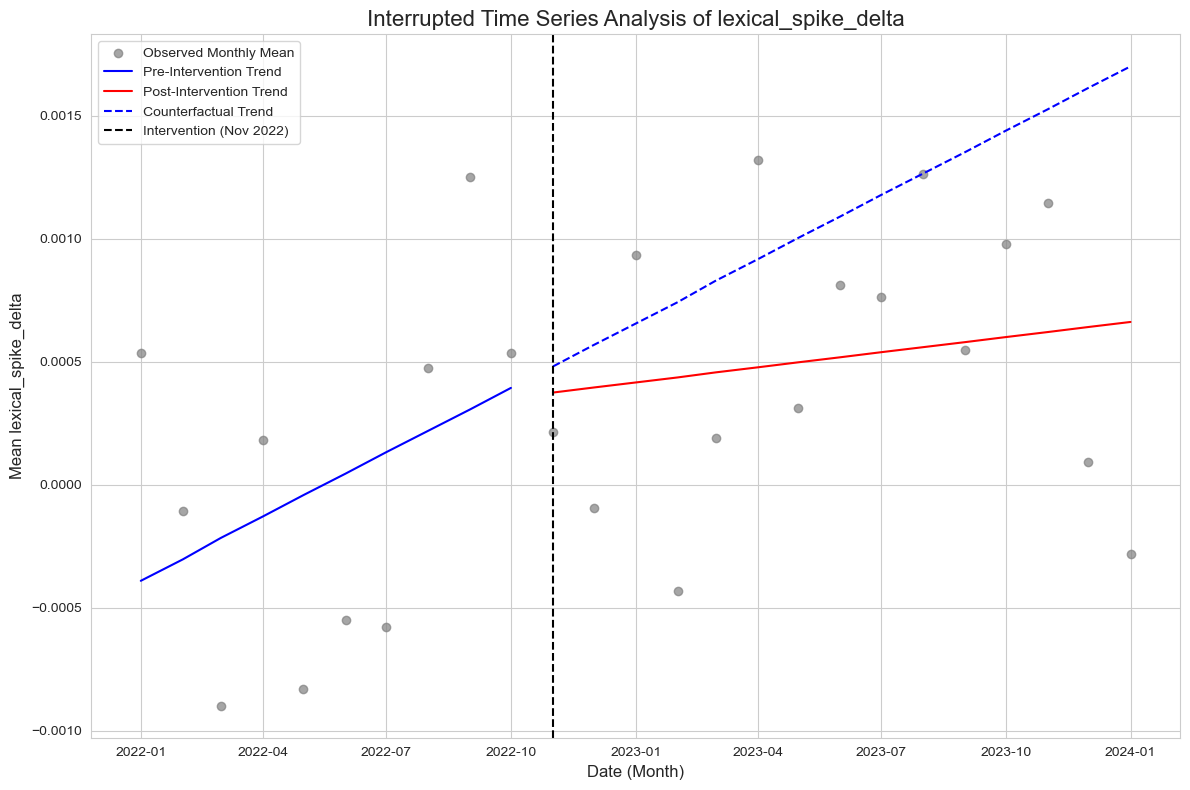

In [23]:
one_feature = 'lexical_spike_delta'
run_its_analysis(df_monthly, one_feature, intervention_date)

In [ ]:
for feature in existing_features:
    print(f"\n\n*** Running detailed analysis for feature '{feature}' ***")
    run_its_analysis(df_monthly, feature, intervention_date)